### 非线性偏微分方程的数据驱动解

--------Data-driven Solutions of Nonlinear Partial Differential Equations

在这篇分为两部分的论文的[第一部分](https://arxiv.org/abs/1711.10561)中，我们将重点讨论计算**一般形式偏微分方程**(partial differential equations of the general form)的数据驱动解
$$
\large u_t + \cal N[u] = 0, x\in Ω, t \in [0,T],
$$
其中 $u(t,x)$ 表示潜在（隐藏）解，$\cal N[⋅]$ 是一个**非线性微分算子**(nonlinear differential operator)，$Ω$ 是 $R^D$ 的子集。接下来，我们提出了两类不同的算法，即**连续时间模型和离散时间模型**(continuous and discrete time models)，并通过不同的基准问题来突出它们的性质和性能。[这里](https://github.com/maziarraissi/PINNs)提供了所有代码和数据集。

#### 连续时间模型

--------Continuous Time Models

我们定义 $f(t,x)$ 为
$$
\large f := u_t + \cal N[u],
$$

然后用深度神经网络逼近 $u(t,x)$ 。这个假设产生了一个[物理信息神经网络](https://arxiv.org/abs/1711.10561) $f(t,x)$ 。这个网络可以通过计算图上的演算得到：[反向传播](http://colah.github.io/posts/2015-08-Backprop/)。

##### 示例1(Burgers方程)

作为一个例子，让我们考虑[Burgers方程](https://en.wikipedia.org/wiki/Burgers'_equation)。在一维空间中，Burger方程的Dirichlet边界条件如下
$$
\begin{align}
& \large u_t + uu_x - (0.01/\pi)u_{xx} = 0, x \in [-1,1], t \in [0,1],\\
& \large u(0,x) = -sin(\pi x),\\
& \large u(t,-1) = u(t,1) = 0.\\
\end{align}
$$



让我们定义 $f(t,x)$ 为
$$
\large f := u_t + uu_x - (0.01/\pi)u_{xx},
$$

然后用深度神经网络逼近 $u(t,x)$ 。为了强调这个想法的简单性，让我们用Python来实现它，只需要一点点[Tensorflow](https://www.tensorflow.org/)。为此， $u(t,x)$ 可以简单地定义为

In [1]:
def u(t, x):
    u = neural_net(tf.concat([t,x],1), weights, biases)
    return u

相应地，[物理信息神经网络](https://arxiv.org/abs/1711.10561)$f(t,x)$ 采用以下形式

In [2]:
def f(t, x):
    u = u(t, x)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u*u_x - (0.01/tf.pi)*u_xx
    return f

通过最小化均方误差损失，可以学习神经网络 $u(t,x)$ 和 $f(t,x)$ 之间的共享参数
$$
\begin{align}
& MSE = MSE_u + MSF_f,\\
& MSE_u = \frac 1 {N_u} \sum^{N_u}_{i=1} |u(t^i_u, x^i_u) - u^i|^2,\\
& MSE_f = \frac 1 {N_f} \sum^{N_f}_{i=1} |f(t^i_f, x^i_f)|^2.\\
\end{align}
$$
这里，$\{ {t^i_u, x^i_u, u^i} \}^{N_u}_{i=1}$ 表示 $u(t,x)$ 上的初始和边界训练数据，$\{{t^i_f,x^i_f}\}^{N_f}_{i=1}$指定 $f(t,x)$ 的配置点。损失 $MSE_u$ 对应于初始和边界数据，而 $MSE_f$ 在有限的配置点集上强制执行Burgers方程施加的结构。

### 代码源文件

PINNs-master/appendix/continuous_time_identification%20(Burgers)/Burgers.py

plotting.py 文件会修改matplotlib的latex源，如果电脑上未安装latex，别用plotting.py

In [1]:
"""
@author: Maziar Raissi
"""

import sys
# sys.path.insert(0, '../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata

# from plotting import newfig, savefig

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, np.exp(lambda_2)))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [3]:

nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

######################################################################
######################## Noiseles Data ###############################
######################################################################
noise = 0.0            

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

######################################################################
########################### Noisy Data ###############################
######################################################################
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)

u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.sess.run(model.lambda_1)
lambda_2_value_noisy = model.sess.run(model.lambda_2)
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu)/nu * 100

print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
print('Error lambda_2: %f%%' % (error_lambda_2_noisy))                           


Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Loss: 3.949374e-01, l1: 0.00000, l2: 0.00248
Loss: 7.736639e-01, l1: 0.00000, l2: 0.00248
Loss: 3.374787e-01, l1: 0.00000, l2: 0.00248
Loss: 2.880107e-01, l1: 0.00016, l2: 0.00248
Loss: 8.284917e+00, l1: 0.00138, l2: 0.00248
Loss: 2.714846e-01, l1: 0.00022, l2: 0.00248
Loss: 2.565792e-01, l1: 0.00035, l2: 0.00248
Loss: 2.386290e-01, l1: 0.00033, l2: 0.00248
Loss: 2.358943e-01, l1: 0.00035, l2: 0.00248
Loss: 2.344091e-01, l1: 0.00035, l2: 0.00248
Loss: 2.298073e-01, l1: 0.00035, l2: 0.00248
Loss: 2.098748e-01, l1: 0.00028, l2: 0.00248
Loss: 2.486481e-01, l1: -0.00004, l2: 0.00248
Loss: 1.964649e-01, l1: 0.00017, 

Loss: 8.906946e-03, l1: 0.54290, l2: 0.00330
Loss: 8.894049e-03, l1: 0.54421, l2: 0.00331
Loss: 8.874303e-03, l1: 0.54721, l2: 0.00334
Loss: 8.862367e-03, l1: 0.55056, l2: 0.00336
Loss: 8.854466e-03, l1: 0.55076, l2: 0.00335
Loss: 8.844573e-03, l1: 0.55180, l2: 0.00336
Loss: 8.831756e-03, l1: 0.55310, l2: 0.00337
Loss: 8.799097e-03, l1: 0.55622, l2: 0.00339
Loss: 8.751788e-03, l1: 0.56021, l2: 0.00342
Loss: 8.695668e-03, l1: 0.56220, l2: 0.00344
Loss: 8.637357e-03, l1: 0.56449, l2: 0.00346
Loss: 8.563878e-03, l1: 0.56404, l2: 0.00347
Loss: 8.501646e-03, l1: 0.56696, l2: 0.00347
Loss: 8.454602e-03, l1: 0.57724, l2: 0.00352
Loss: 8.398921e-03, l1: 0.58662, l2: 0.00355
Loss: 8.371396e-03, l1: 0.59566, l2: 0.00358
Loss: 8.353544e-03, l1: 0.59926, l2: 0.00359
Loss: 8.338775e-03, l1: 0.60154, l2: 0.00360
Loss: 8.310403e-03, l1: 0.60321, l2: 0.00360
Loss: 8.446488e-03, l1: 0.59606, l2: 0.00363
Loss: 8.295795e-03, l1: 0.60151, l2: 0.00361
Loss: 8.249473e-03, l1: 0.60304, l2: 0.00363
Loss: 8.18

Loss: 3.754813e-03, l1: 0.80432, l2: 0.00497
Loss: 3.733589e-03, l1: 0.80306, l2: 0.00497
Loss: 3.712935e-03, l1: 0.79783, l2: 0.00495
Loss: 3.697993e-03, l1: 0.79524, l2: 0.00494
Loss: 3.689783e-03, l1: 0.79466, l2: 0.00493
Loss: 3.678470e-03, l1: 0.79546, l2: 0.00493
Loss: 3.660469e-03, l1: 0.79915, l2: 0.00493
Loss: 3.643484e-03, l1: 0.80123, l2: 0.00492
Loss: 3.625683e-03, l1: 0.80275, l2: 0.00492
Loss: 3.598465e-03, l1: 0.80465, l2: 0.00492
Loss: 3.561536e-03, l1: 0.80614, l2: 0.00490
Loss: 3.536511e-03, l1: 0.81216, l2: 0.00490
Loss: 3.504068e-03, l1: 0.81399, l2: 0.00489
Loss: 3.479296e-03, l1: 0.81190, l2: 0.00489
Loss: 3.452112e-03, l1: 0.81079, l2: 0.00490
Loss: 3.454951e-03, l1: 0.81813, l2: 0.00492
Loss: 3.439481e-03, l1: 0.81428, l2: 0.00491
Loss: 3.476758e-03, l1: 0.81814, l2: 0.00492
Loss: 3.427421e-03, l1: 0.81555, l2: 0.00491
Loss: 3.411914e-03, l1: 0.81841, l2: 0.00492
Loss: 3.396899e-03, l1: 0.82394, l2: 0.00494
Loss: 3.386453e-03, l1: 0.82490, l2: 0.00494
Loss: 3.37

Loss: 1.582804e-03, l1: 0.90784, l2: 0.00497
Loss: 1.578381e-03, l1: 0.90818, l2: 0.00497
Loss: 1.573751e-03, l1: 0.90869, l2: 0.00497
Loss: 1.569312e-03, l1: 0.90980, l2: 0.00498
Loss: 1.564613e-03, l1: 0.91043, l2: 0.00498
Loss: 1.559097e-03, l1: 0.91082, l2: 0.00498
Loss: 1.648408e-03, l1: 0.91199, l2: 0.00498
Loss: 1.557544e-03, l1: 0.91096, l2: 0.00498
Loss: 1.555491e-03, l1: 0.91209, l2: 0.00499
Loss: 1.550639e-03, l1: 0.91134, l2: 0.00499
Loss: 1.545261e-03, l1: 0.91049, l2: 0.00498
Loss: 1.540872e-03, l1: 0.91109, l2: 0.00498
Loss: 1.535062e-03, l1: 0.91209, l2: 0.00498
Loss: 1.529163e-03, l1: 0.91374, l2: 0.00499
Loss: 1.524132e-03, l1: 0.91515, l2: 0.00499
Loss: 1.545141e-03, l1: 0.91930, l2: 0.00502
Loss: 1.521680e-03, l1: 0.91616, l2: 0.00500
Loss: 1.519841e-03, l1: 0.91639, l2: 0.00500
Loss: 1.518516e-03, l1: 0.91589, l2: 0.00500
Loss: 1.516216e-03, l1: 0.91548, l2: 0.00500
Loss: 1.510832e-03, l1: 0.91487, l2: 0.00501
Loss: 1.504751e-03, l1: 0.91512, l2: 0.00501
Loss: 1.49

Loss: 7.732495e-04, l1: 0.96109, l2: 0.00498
Loss: 7.665529e-04, l1: 0.95783, l2: 0.00498
Loss: 7.616667e-04, l1: 0.95548, l2: 0.00497
Loss: 7.589029e-04, l1: 0.95453, l2: 0.00497
Loss: 7.572968e-04, l1: 0.95518, l2: 0.00497
Loss: 7.560799e-04, l1: 0.95529, l2: 0.00496
Loss: 7.554552e-04, l1: 0.95516, l2: 0.00496
Loss: 7.542738e-04, l1: 0.95471, l2: 0.00496
Loss: 7.518596e-04, l1: 0.95417, l2: 0.00495
Loss: 7.508980e-04, l1: 0.95179, l2: 0.00495
Loss: 7.865446e-04, l1: 0.95517, l2: 0.00495
Loss: 7.492525e-04, l1: 0.95238, l2: 0.00495
Loss: 7.468496e-04, l1: 0.95260, l2: 0.00495
Loss: 7.477808e-04, l1: 0.95462, l2: 0.00495
Loss: 7.450755e-04, l1: 0.95351, l2: 0.00495
Loss: 7.412401e-04, l1: 0.95241, l2: 0.00494
Loss: 7.390572e-04, l1: 0.95128, l2: 0.00494
Loss: 7.366032e-04, l1: 0.94990, l2: 0.00493
Loss: 7.352899e-04, l1: 0.94966, l2: 0.00493
Loss: 7.337016e-04, l1: 0.94965, l2: 0.00492
Loss: 7.322903e-04, l1: 0.94998, l2: 0.00492
Loss: 7.339413e-04, l1: 0.94939, l2: 0.00492
Loss: 7.31

Loss: 4.094943e-04, l1: 0.97714, l2: 0.00448
Loss: 4.041094e-04, l1: 0.97767, l2: 0.00450
Loss: 4.034282e-04, l1: 0.97767, l2: 0.00449
Loss: 4.027035e-04, l1: 0.97739, l2: 0.00449
Loss: 4.022100e-04, l1: 0.97734, l2: 0.00448
Loss: 4.012199e-04, l1: 0.97698, l2: 0.00448
Loss: 4.005817e-04, l1: 0.97693, l2: 0.00448
Loss: 3.998420e-04, l1: 0.97684, l2: 0.00448
Loss: 3.984041e-04, l1: 0.97680, l2: 0.00448
Loss: 3.974392e-04, l1: 0.97723, l2: 0.00449
Loss: 3.959582e-04, l1: 0.97727, l2: 0.00449
Loss: 3.941361e-04, l1: 0.97800, l2: 0.00448
Loss: 3.932306e-04, l1: 0.97855, l2: 0.00448
Loss: 3.916546e-04, l1: 0.97952, l2: 0.00447
Loss: 3.898041e-04, l1: 0.98007, l2: 0.00446
Loss: 3.954009e-04, l1: 0.97873, l2: 0.00444
Loss: 3.891656e-04, l1: 0.97975, l2: 0.00446
Loss: 3.883555e-04, l1: 0.97992, l2: 0.00446
Loss: 3.878980e-04, l1: 0.97983, l2: 0.00446
Loss: 3.873348e-04, l1: 0.97983, l2: 0.00446
Loss: 3.875167e-04, l1: 0.98083, l2: 0.00447
Loss: 3.868712e-04, l1: 0.98029, l2: 0.00446
Loss: 3.85

Loss: 2.452907e-04, l1: 0.99001, l2: 0.00410
Loss: 2.442539e-04, l1: 0.98929, l2: 0.00410
Loss: 2.436669e-04, l1: 0.98900, l2: 0.00410
Loss: 2.434402e-04, l1: 0.98898, l2: 0.00410
Loss: 2.432840e-04, l1: 0.98895, l2: 0.00410
Loss: 2.429194e-04, l1: 0.98875, l2: 0.00410
Loss: 2.423558e-04, l1: 0.98885, l2: 0.00409
Loss: 2.418008e-04, l1: 0.98875, l2: 0.00408
Loss: 2.406687e-04, l1: 0.98919, l2: 0.00408
Loss: 2.396576e-04, l1: 0.98946, l2: 0.00408
Loss: 2.387470e-04, l1: 0.98979, l2: 0.00408
Loss: 2.382240e-04, l1: 0.98994, l2: 0.00408
Loss: 2.370681e-04, l1: 0.98975, l2: 0.00408
Loss: 2.361790e-04, l1: 0.98960, l2: 0.00407
Loss: 2.525184e-04, l1: 0.98526, l2: 0.00406
Loss: 2.355603e-04, l1: 0.98890, l2: 0.00407
Loss: 2.346542e-04, l1: 0.98854, l2: 0.00407
Loss: 2.337871e-04, l1: 0.98794, l2: 0.00407
Loss: 2.335756e-04, l1: 0.98785, l2: 0.00407
Loss: 2.330246e-04, l1: 0.98768, l2: 0.00406
Loss: 2.325742e-04, l1: 0.98752, l2: 0.00406
Loss: 2.318170e-04, l1: 0.98716, l2: 0.00405
Loss: 3.53

Loss: 1.686796e-04, l1: 0.98621, l2: 0.00382
Loss: 1.676166e-04, l1: 0.98649, l2: 0.00381
Loss: 1.672973e-04, l1: 0.98640, l2: 0.00382
Loss: 1.665563e-04, l1: 0.98638, l2: 0.00382
Loss: 1.662724e-04, l1: 0.98642, l2: 0.00382
Loss: 1.658393e-04, l1: 0.98643, l2: 0.00381
Loss: 1.653795e-04, l1: 0.98650, l2: 0.00381
Loss: 1.645875e-04, l1: 0.98649, l2: 0.00380
Loss: 1.638296e-04, l1: 0.98672, l2: 0.00380
Loss: 1.634519e-04, l1: 0.98691, l2: 0.00380
Loss: 1.632865e-04, l1: 0.98700, l2: 0.00380
Loss: 1.630197e-04, l1: 0.98716, l2: 0.00380
Loss: 1.625597e-04, l1: 0.98741, l2: 0.00380
Loss: 1.620972e-04, l1: 0.98798, l2: 0.00379
Loss: 1.615233e-04, l1: 0.98801, l2: 0.00379
Loss: 1.611055e-04, l1: 0.98767, l2: 0.00380
Loss: 1.608544e-04, l1: 0.98761, l2: 0.00380
Loss: 1.606113e-04, l1: 0.98770, l2: 0.00380
Loss: 1.603507e-04, l1: 0.98779, l2: 0.00379
Loss: 1.605580e-04, l1: 0.98786, l2: 0.00379
Loss: 1.602226e-04, l1: 0.98782, l2: 0.00379
Loss: 1.599086e-04, l1: 0.98788, l2: 0.00379
Loss: 1.59

Loss: 1.032592e-04, l1: 0.98444, l2: 0.00354
Loss: 1.031333e-04, l1: 0.98454, l2: 0.00354
Loss: 1.029106e-04, l1: 0.98422, l2: 0.00354
Loss: 1.027426e-04, l1: 0.98444, l2: 0.00354
Loss: 1.026365e-04, l1: 0.98443, l2: 0.00354
Loss: 1.025363e-04, l1: 0.98427, l2: 0.00354
Loss: 1.024333e-04, l1: 0.98423, l2: 0.00354
Loss: 1.021366e-04, l1: 0.98382, l2: 0.00354
Loss: 1.018323e-04, l1: 0.98384, l2: 0.00354
Loss: 1.016194e-04, l1: 0.98382, l2: 0.00354
Loss: 1.013129e-04, l1: 0.98368, l2: 0.00354
Loss: 1.011380e-04, l1: 0.98366, l2: 0.00354
Loss: 1.012227e-04, l1: 0.98357, l2: 0.00353
Loss: 1.010747e-04, l1: 0.98363, l2: 0.00354
Loss: 1.009694e-04, l1: 0.98362, l2: 0.00354
Loss: 1.008495e-04, l1: 0.98360, l2: 0.00353
Loss: 1.007173e-04, l1: 0.98365, l2: 0.00353
Loss: 1.004516e-04, l1: 0.98371, l2: 0.00353
Loss: 1.046050e-04, l1: 0.98514, l2: 0.00354
Loss: 1.003830e-04, l1: 0.98387, l2: 0.00353
Loss: 1.000565e-04, l1: 0.98391, l2: 0.00353
Loss: 9.979506e-05, l1: 0.98408, l2: 0.00352
Loss: 9.95

Loss: 7.461645e-05, l1: 0.99378, l2: 0.00337
Loss: 7.385478e-05, l1: 0.99273, l2: 0.00337
Loss: 7.377519e-05, l1: 0.99272, l2: 0.00337
Loss: 7.370032e-05, l1: 0.99273, l2: 0.00337
Loss: 7.360197e-05, l1: 0.99266, l2: 0.00337
Loss: 7.342952e-05, l1: 0.99254, l2: 0.00337
Loss: 7.328676e-05, l1: 0.99232, l2: 0.00337
Loss: 7.398707e-05, l1: 0.99220, l2: 0.00337
Loss: 7.318803e-05, l1: 0.99228, l2: 0.00337
Loss: 7.289965e-05, l1: 0.99226, l2: 0.00337
Loss: 7.272069e-05, l1: 0.99236, l2: 0.00337
Loss: 7.256978e-05, l1: 0.99261, l2: 0.00337
Loss: 7.249711e-05, l1: 0.99271, l2: 0.00337
Loss: 7.241956e-05, l1: 0.99287, l2: 0.00336
Loss: 7.228865e-05, l1: 0.99298, l2: 0.00336
Loss: 7.210678e-05, l1: 0.99308, l2: 0.00336
Loss: 7.170897e-05, l1: 0.99330, l2: 0.00336
Loss: 7.153616e-05, l1: 0.99349, l2: 0.00336
Loss: 7.140442e-05, l1: 0.99363, l2: 0.00336
Loss: 7.123863e-05, l1: 0.99368, l2: 0.00336
Loss: 7.099575e-05, l1: 0.99385, l2: 0.00336
Loss: 7.085207e-05, l1: 0.99383, l2: 0.00336
Loss: 7.07

Loss: 5.240798e-05, l1: 0.99652, l2: 0.00330
Loss: 5.211590e-05, l1: 0.99628, l2: 0.00330
Loss: 5.184883e-05, l1: 0.99613, l2: 0.00330
Loss: 5.168026e-05, l1: 0.99599, l2: 0.00330
Loss: 5.145007e-05, l1: 0.99578, l2: 0.00330
Loss: 5.132206e-05, l1: 0.99568, l2: 0.00330
Loss: 5.130003e-05, l1: 0.99609, l2: 0.00330
Loss: 5.119417e-05, l1: 0.99590, l2: 0.00330
Loss: 5.112699e-05, l1: 0.99591, l2: 0.00330
Loss: 5.107101e-05, l1: 0.99604, l2: 0.00330
Loss: 5.101756e-05, l1: 0.99618, l2: 0.00330
Loss: 5.185185e-05, l1: 0.99666, l2: 0.00331
Loss: 5.098881e-05, l1: 0.99625, l2: 0.00330
Loss: 5.091539e-05, l1: 0.99641, l2: 0.00330
Loss: 5.083523e-05, l1: 0.99649, l2: 0.00330
Loss: 5.072413e-05, l1: 0.99649, l2: 0.00330
Loss: 5.058096e-05, l1: 0.99639, l2: 0.00330
Loss: 5.097518e-05, l1: 0.99646, l2: 0.00330
Loss: 5.052184e-05, l1: 0.99641, l2: 0.00330
Loss: 5.037548e-05, l1: 0.99629, l2: 0.00330
Loss: 5.025740e-05, l1: 0.99621, l2: 0.00330
Loss: 5.017770e-05, l1: 0.99622, l2: 0.00330
Loss: 5.01

Loss: 3.785152e-05, l1: 0.99527, l2: 0.00323
Loss: 3.779169e-05, l1: 0.99527, l2: 0.00323
Loss: 3.771739e-05, l1: 0.99536, l2: 0.00323
Loss: 3.768101e-05, l1: 0.99545, l2: 0.00323
Loss: 3.762317e-05, l1: 0.99561, l2: 0.00323
Loss: 3.756777e-05, l1: 0.99573, l2: 0.00323
Loss: 3.749994e-05, l1: 0.99580, l2: 0.00323
Loss: 3.770324e-05, l1: 0.99610, l2: 0.00323
Loss: 3.744005e-05, l1: 0.99590, l2: 0.00323
Loss: 3.737316e-05, l1: 0.99581, l2: 0.00323
Loss: 3.750239e-05, l1: 0.99567, l2: 0.00323
Loss: 3.731800e-05, l1: 0.99576, l2: 0.00323
Loss: 3.722024e-05, l1: 0.99564, l2: 0.00323
Loss: 3.710689e-05, l1: 0.99563, l2: 0.00323
Loss: 3.703146e-05, l1: 0.99567, l2: 0.00323
Loss: 3.699133e-05, l1: 0.99574, l2: 0.00323
Loss: 3.703552e-05, l1: 0.99584, l2: 0.00323
Loss: 3.697016e-05, l1: 0.99578, l2: 0.00323
Loss: 3.693222e-05, l1: 0.99583, l2: 0.00323
Loss: 3.690501e-05, l1: 0.99583, l2: 0.00323
Loss: 3.685795e-05, l1: 0.99578, l2: 0.00323
Loss: 3.703462e-05, l1: 0.99574, l2: 0.00323
Loss: 3.68

Loss: 2.936576e-05, l1: 0.99616, l2: 0.00320
Loss: 2.943780e-05, l1: 0.99579, l2: 0.00320
Loss: 2.932880e-05, l1: 0.99603, l2: 0.00320
Loss: 2.928162e-05, l1: 0.99605, l2: 0.00320
Loss: 2.922754e-05, l1: 0.99611, l2: 0.00320
Loss: 2.918598e-05, l1: 0.99617, l2: 0.00320
Loss: 2.914991e-05, l1: 0.99622, l2: 0.00320
Loss: 2.910927e-05, l1: 0.99622, l2: 0.00320
Loss: 2.904349e-05, l1: 0.99621, l2: 0.00320
Loss: 2.934287e-05, l1: 0.99592, l2: 0.00320
Loss: 2.902847e-05, l1: 0.99616, l2: 0.00320
Loss: 2.897012e-05, l1: 0.99611, l2: 0.00320
Loss: 2.893492e-05, l1: 0.99611, l2: 0.00320
Loss: 2.890085e-05, l1: 0.99604, l2: 0.00320
Loss: 2.885802e-05, l1: 0.99613, l2: 0.00320
Loss: 2.880314e-05, l1: 0.99614, l2: 0.00320
Loss: 2.875269e-05, l1: 0.99628, l2: 0.00320
Loss: 2.869899e-05, l1: 0.99635, l2: 0.00320
Loss: 2.859909e-05, l1: 0.99639, l2: 0.00320
Loss: 2.851665e-05, l1: 0.99630, l2: 0.00320
Loss: 2.889049e-05, l1: 0.99677, l2: 0.00320
Loss: 2.848695e-05, l1: 0.99640, l2: 0.00320
Loss: 2.84

Loss: 2.326125e-05, l1: 0.99788, l2: 0.00319
Loss: 2.324661e-05, l1: 0.99789, l2: 0.00319
Loss: 2.344613e-05, l1: 0.99805, l2: 0.00319
Loss: 2.324162e-05, l1: 0.99791, l2: 0.00319
Loss: 2.321490e-05, l1: 0.99797, l2: 0.00319
Loss: 2.320314e-05, l1: 0.99801, l2: 0.00319
Loss: 2.316418e-05, l1: 0.99812, l2: 0.00319
Loss: 2.308905e-05, l1: 0.99829, l2: 0.00319
Loss: 2.316103e-05, l1: 0.99857, l2: 0.00319
Loss: 2.306421e-05, l1: 0.99838, l2: 0.00319
Loss: 2.301605e-05, l1: 0.99845, l2: 0.00319
Loss: 2.298747e-05, l1: 0.99842, l2: 0.00319
Loss: 2.297309e-05, l1: 0.99851, l2: 0.00319
Loss: 2.294492e-05, l1: 0.99847, l2: 0.00319
Loss: 2.290796e-05, l1: 0.99847, l2: 0.00319
Loss: 2.287879e-05, l1: 0.99853, l2: 0.00319
Loss: 2.285067e-05, l1: 0.99860, l2: 0.00319
Loss: 2.283490e-05, l1: 0.99864, l2: 0.00319
Loss: 2.282494e-05, l1: 0.99865, l2: 0.00319
Loss: 2.281758e-05, l1: 0.99865, l2: 0.00319
Loss: 2.282129e-05, l1: 0.99863, l2: 0.00319
Loss: 2.281257e-05, l1: 0.99864, l2: 0.00319
Loss: 2.28

Loss: 1.934709e-05, l1: 0.99860, l2: 0.00320
Loss: 1.932031e-05, l1: 0.99853, l2: 0.00320
Loss: 1.930910e-05, l1: 0.99853, l2: 0.00320
Loss: 1.928333e-05, l1: 0.99852, l2: 0.00320
Loss: 1.927071e-05, l1: 0.99850, l2: 0.00320
Loss: 1.932264e-05, l1: 0.99856, l2: 0.00320
Loss: 1.926304e-05, l1: 0.99852, l2: 0.00320
Loss: 1.923837e-05, l1: 0.99844, l2: 0.00320
Loss: 1.923005e-05, l1: 0.99842, l2: 0.00320
Loss: 1.922076e-05, l1: 0.99843, l2: 0.00320
Loss: 1.921287e-05, l1: 0.99844, l2: 0.00320
Loss: 1.925430e-05, l1: 0.99854, l2: 0.00320
Loss: 1.920615e-05, l1: 0.99847, l2: 0.00320
Loss: 1.918402e-05, l1: 0.99844, l2: 0.00320
Loss: 1.916879e-05, l1: 0.99847, l2: 0.00320
Loss: 1.915365e-05, l1: 0.99848, l2: 0.00320
Loss: 1.914190e-05, l1: 0.99847, l2: 0.00320
Loss: 1.912574e-05, l1: 0.99845, l2: 0.00320
Loss: 1.911248e-05, l1: 0.99844, l2: 0.00320
Loss: 1.910222e-05, l1: 0.99844, l2: 0.00320
Loss: 1.909628e-05, l1: 0.99847, l2: 0.00320
Loss: 1.908946e-05, l1: 0.99851, l2: 0.00320
Loss: 1.90

It: 40, Loss: 2.436e-01, Lambda_1: -0.032, Lambda_2: 0.002571, Time: 0.11
It: 50, Loss: 2.349e-01, Lambda_1: -0.044, Lambda_2: 0.002605, Time: 0.11
It: 60, Loss: 2.216e-01, Lambda_1: -0.055, Lambda_2: 0.002642, Time: 0.11
It: 70, Loss: 1.944e-01, Lambda_1: -0.064, Lambda_2: 0.002676, Time: 0.11
It: 80, Loss: 1.461e-01, Lambda_1: -0.067, Lambda_2: 0.002683, Time: 0.11
It: 90, Loss: 9.770e-02, Lambda_1: -0.060, Lambda_2: 0.002638, Time: 0.11
It: 100, Loss: 7.170e-02, Lambda_1: -0.041, Lambda_2: 0.002582, Time: 0.12
It: 110, Loss: 5.985e-02, Lambda_1: -0.018, Lambda_2: 0.002524, Time: 0.11
It: 120, Loss: 5.041e-02, Lambda_1: 0.005, Lambda_2: 0.002468, Time: 0.11
It: 130, Loss: 4.353e-02, Lambda_1: 0.024, Lambda_2: 0.002422, Time: 0.11
It: 140, Loss: 4.003e-02, Lambda_1: 0.039, Lambda_2: 0.002393, Time: 0.11
It: 150, Loss: 3.852e-02, Lambda_1: 0.048, Lambda_2: 0.002380, Time: 0.11
It: 160, Loss: 3.769e-02, Lambda_1: 0.051, Lambda_2: 0.002377, Time: 0.11
It: 170, Loss: 3.704e-02, Lambda_1: 

It: 1160, Loss: 7.082e-03, Lambda_1: 0.549, Lambda_2: 0.003206, Time: 0.13
It: 1170, Loss: 6.985e-03, Lambda_1: 0.554, Lambda_2: 0.003215, Time: 0.11
It: 1180, Loss: 6.889e-03, Lambda_1: 0.558, Lambda_2: 0.003225, Time: 0.11
It: 1190, Loss: 6.796e-03, Lambda_1: 0.562, Lambda_2: 0.003234, Time: 0.11
It: 1200, Loss: 6.915e-03, Lambda_1: 0.566, Lambda_2: 0.003242, Time: 0.13
It: 1210, Loss: 6.653e-03, Lambda_1: 0.570, Lambda_2: 0.003250, Time: 0.13
It: 1220, Loss: 1.763e-02, Lambda_1: 0.573, Lambda_2: 0.003255, Time: 0.11
It: 1230, Loss: 1.003e-01, Lambda_1: 0.571, Lambda_2: 0.003200, Time: 0.13
It: 1240, Loss: 4.025e-02, Lambda_1: 0.568, Lambda_2: 0.003182, Time: 0.11
It: 1250, Loss: 2.189e-02, Lambda_1: 0.559, Lambda_2: 0.003192, Time: 0.11
It: 1260, Loss: 1.354e-02, Lambda_1: 0.548, Lambda_2: 0.003204, Time: 0.11
It: 1270, Loss: 9.321e-03, Lambda_1: 0.537, Lambda_2: 0.003231, Time: 0.11
It: 1280, Loss: 8.257e-03, Lambda_1: 0.530, Lambda_2: 0.003252, Time: 0.11
It: 1290, Loss: 7.612e-03

It: 2260, Loss: 2.552e-03, Lambda_1: 0.770, Lambda_2: 0.003903, Time: 0.11
It: 2270, Loss: 2.476e-03, Lambda_1: 0.771, Lambda_2: 0.003907, Time: 0.11
It: 2280, Loss: 2.432e-03, Lambda_1: 0.773, Lambda_2: 0.003912, Time: 0.11
It: 2290, Loss: 2.396e-03, Lambda_1: 0.775, Lambda_2: 0.003916, Time: 0.11
It: 2300, Loss: 2.364e-03, Lambda_1: 0.776, Lambda_2: 0.003920, Time: 0.11
It: 2310, Loss: 2.333e-03, Lambda_1: 0.778, Lambda_2: 0.003924, Time: 0.11
It: 2320, Loss: 2.341e-03, Lambda_1: 0.780, Lambda_2: 0.003928, Time: 0.11
It: 2330, Loss: 2.279e-03, Lambda_1: 0.782, Lambda_2: 0.003931, Time: 0.11
It: 2340, Loss: 2.421e-03, Lambda_1: 0.784, Lambda_2: 0.003935, Time: 0.11
It: 2350, Loss: 2.490e-03, Lambda_1: 0.785, Lambda_2: 0.003938, Time: 0.11
It: 2360, Loss: 2.200e-03, Lambda_1: 0.787, Lambda_2: 0.003941, Time: 0.11
It: 2370, Loss: 2.463e-03, Lambda_1: 0.789, Lambda_2: 0.003944, Time: 0.11
It: 2380, Loss: 3.237e-03, Lambda_1: 0.791, Lambda_2: 0.003946, Time: 0.11
It: 2390, Loss: 2.377e-03

It: 3360, Loss: 1.129e-03, Lambda_1: 0.855, Lambda_2: 0.004073, Time: 0.11
It: 3370, Loss: 1.122e-03, Lambda_1: 0.856, Lambda_2: 0.004073, Time: 0.11
It: 3380, Loss: 1.115e-03, Lambda_1: 0.857, Lambda_2: 0.004074, Time: 0.11
It: 3390, Loss: 1.107e-03, Lambda_1: 0.858, Lambda_2: 0.004075, Time: 0.11
It: 3400, Loss: 1.100e-03, Lambda_1: 0.859, Lambda_2: 0.004075, Time: 0.11
It: 3410, Loss: 1.093e-03, Lambda_1: 0.859, Lambda_2: 0.004076, Time: 0.13
It: 3420, Loss: 1.086e-03, Lambda_1: 0.860, Lambda_2: 0.004077, Time: 0.12
It: 3430, Loss: 1.080e-03, Lambda_1: 0.861, Lambda_2: 0.004077, Time: 0.11
It: 3440, Loss: 1.073e-03, Lambda_1: 0.862, Lambda_2: 0.004078, Time: 0.11
It: 3450, Loss: 1.066e-03, Lambda_1: 0.863, Lambda_2: 0.004079, Time: 0.11
It: 3460, Loss: 1.059e-03, Lambda_1: 0.863, Lambda_2: 0.004079, Time: 0.13
It: 3470, Loss: 1.052e-03, Lambda_1: 0.864, Lambda_2: 0.004080, Time: 0.13
It: 3480, Loss: 1.046e-03, Lambda_1: 0.865, Lambda_2: 0.004080, Time: 0.11
It: 3490, Loss: 1.039e-03

It: 4460, Loss: 5.404e-04, Lambda_1: 0.929, Lambda_2: 0.004128, Time: 0.12
It: 4470, Loss: 7.643e-04, Lambda_1: 0.929, Lambda_2: 0.004129, Time: 0.11
It: 4480, Loss: 9.973e-04, Lambda_1: 0.930, Lambda_2: 0.004128, Time: 0.11
It: 4490, Loss: 6.640e-04, Lambda_1: 0.930, Lambda_2: 0.004128, Time: 0.11
It: 4500, Loss: 6.689e-04, Lambda_1: 0.931, Lambda_2: 0.004129, Time: 0.12
It: 4510, Loss: 5.549e-04, Lambda_1: 0.931, Lambda_2: 0.004129, Time: 0.12
It: 4520, Loss: 5.492e-04, Lambda_1: 0.931, Lambda_2: 0.004129, Time: 0.11
It: 4530, Loss: 5.942e-04, Lambda_1: 0.932, Lambda_2: 0.004129, Time: 0.11
It: 4540, Loss: 6.388e-04, Lambda_1: 0.932, Lambda_2: 0.004129, Time: 0.11
It: 4550, Loss: 6.551e-04, Lambda_1: 0.933, Lambda_2: 0.004130, Time: 0.12
It: 4560, Loss: 7.224e-04, Lambda_1: 0.933, Lambda_2: 0.004130, Time: 0.12
It: 4570, Loss: 5.554e-04, Lambda_1: 0.934, Lambda_2: 0.004130, Time: 0.11
It: 4580, Loss: 5.136e-04, Lambda_1: 0.934, Lambda_2: 0.004130, Time: 0.12
It: 4590, Loss: 5.817e-04

It: 5560, Loss: 6.094e-04, Lambda_1: 0.959, Lambda_2: 0.004126, Time: 0.11
It: 5570, Loss: 4.096e-04, Lambda_1: 0.959, Lambda_2: 0.004125, Time: 0.11
It: 5580, Loss: 5.448e-04, Lambda_1: 0.959, Lambda_2: 0.004126, Time: 0.12
It: 5590, Loss: 3.301e-04, Lambda_1: 0.959, Lambda_2: 0.004125, Time: 0.13
It: 5600, Loss: 3.048e-04, Lambda_1: 0.960, Lambda_2: 0.004125, Time: 0.12
It: 5610, Loss: 5.647e-04, Lambda_1: 0.960, Lambda_2: 0.004125, Time: 0.11
It: 5620, Loss: 4.260e-04, Lambda_1: 0.960, Lambda_2: 0.004125, Time: 0.12
It: 5630, Loss: 5.016e-04, Lambda_1: 0.960, Lambda_2: 0.004124, Time: 0.14
It: 5640, Loss: 3.643e-04, Lambda_1: 0.960, Lambda_2: 0.004124, Time: 0.12
It: 5650, Loss: 3.070e-04, Lambda_1: 0.960, Lambda_2: 0.004124, Time: 0.11
It: 5660, Loss: 4.113e-04, Lambda_1: 0.961, Lambda_2: 0.004124, Time: 0.11
It: 5670, Loss: 6.386e-04, Lambda_1: 0.961, Lambda_2: 0.004124, Time: 0.11
It: 5680, Loss: 4.927e-04, Lambda_1: 0.961, Lambda_2: 0.004124, Time: 0.13
It: 5690, Loss: 3.782e-04

It: 6660, Loss: 2.528e-04, Lambda_1: 0.971, Lambda_2: 0.004105, Time: 0.11
It: 6670, Loss: 4.779e-04, Lambda_1: 0.971, Lambda_2: 0.004105, Time: 0.11
It: 6680, Loss: 3.537e-04, Lambda_1: 0.972, Lambda_2: 0.004105, Time: 0.11
It: 6690, Loss: 4.376e-04, Lambda_1: 0.972, Lambda_2: 0.004105, Time: 0.11
It: 6700, Loss: 3.756e-04, Lambda_1: 0.972, Lambda_2: 0.004105, Time: 0.12
It: 6710, Loss: 2.471e-04, Lambda_1: 0.972, Lambda_2: 0.004104, Time: 0.13
It: 6720, Loss: 5.833e-04, Lambda_1: 0.972, Lambda_2: 0.004105, Time: 0.14
It: 6730, Loss: 2.443e-04, Lambda_1: 0.972, Lambda_2: 0.004104, Time: 0.14
It: 6740, Loss: 5.133e-04, Lambda_1: 0.972, Lambda_2: 0.004104, Time: 0.12
It: 6750, Loss: 2.417e-04, Lambda_1: 0.972, Lambda_2: 0.004103, Time: 0.12
It: 6760, Loss: 3.796e-04, Lambda_1: 0.972, Lambda_2: 0.004104, Time: 0.11
It: 6770, Loss: 4.087e-04, Lambda_1: 0.972, Lambda_2: 0.004103, Time: 0.11
It: 6780, Loss: 3.229e-04, Lambda_1: 0.972, Lambda_2: 0.004103, Time: 0.12
It: 6790, Loss: 4.279e-04

It: 7760, Loss: 3.737e-04, Lambda_1: 0.978, Lambda_2: 0.004081, Time: 0.12
It: 7770, Loss: 4.015e-04, Lambda_1: 0.978, Lambda_2: 0.004081, Time: 0.13
It: 7780, Loss: 2.979e-04, Lambda_1: 0.978, Lambda_2: 0.004081, Time: 0.12
It: 7790, Loss: 5.367e-04, Lambda_1: 0.978, Lambda_2: 0.004081, Time: 0.12
It: 7800, Loss: 2.324e-04, Lambda_1: 0.978, Lambda_2: 0.004080, Time: 0.12
It: 7810, Loss: 4.773e-04, Lambda_1: 0.978, Lambda_2: 0.004080, Time: 0.12
It: 7820, Loss: 2.238e-04, Lambda_1: 0.978, Lambda_2: 0.004080, Time: 0.12
It: 7830, Loss: 3.212e-04, Lambda_1: 0.978, Lambda_2: 0.004080, Time: 0.11
It: 7840, Loss: 4.495e-04, Lambda_1: 0.978, Lambda_2: 0.004079, Time: 0.13
It: 7850, Loss: 3.124e-04, Lambda_1: 0.978, Lambda_2: 0.004079, Time: 0.12
It: 7860, Loss: 4.921e-04, Lambda_1: 0.978, Lambda_2: 0.004079, Time: 0.12
It: 7870, Loss: 1.961e-04, Lambda_1: 0.978, Lambda_2: 0.004079, Time: 0.12
It: 7880, Loss: 4.257e-04, Lambda_1: 0.978, Lambda_2: 0.004078, Time: 0.12
It: 7890, Loss: 2.449e-04

It: 8860, Loss: 8.596e-03, Lambda_1: 0.982, Lambda_2: 0.004056, Time: 0.12
It: 8870, Loss: 4.649e-01, Lambda_1: 0.977, Lambda_2: 0.004032, Time: 0.12
It: 8880, Loss: 3.631e-01, Lambda_1: 0.987, Lambda_2: 0.003990, Time: 0.12
It: 8890, Loss: 2.554e-01, Lambda_1: 1.000, Lambda_2: 0.003947, Time: 0.12
It: 8900, Loss: 1.861e-01, Lambda_1: 1.007, Lambda_2: 0.003926, Time: 0.12
It: 8910, Loss: 1.185e-01, Lambda_1: 1.011, Lambda_2: 0.003920, Time: 0.12
It: 8920, Loss: 5.578e-02, Lambda_1: 1.010, Lambda_2: 0.003920, Time: 0.11
It: 8930, Loss: 2.793e-02, Lambda_1: 1.004, Lambda_2: 0.003932, Time: 0.11
It: 8940, Loss: 2.208e-02, Lambda_1: 0.997, Lambda_2: 0.003947, Time: 0.12
It: 8950, Loss: 1.402e-02, Lambda_1: 0.990, Lambda_2: 0.003959, Time: 0.11
It: 8960, Loss: 1.044e-02, Lambda_1: 0.984, Lambda_2: 0.003973, Time: 0.12
It: 8970, Loss: 7.968e-03, Lambda_1: 0.978, Lambda_2: 0.003982, Time: 0.12
It: 8980, Loss: 6.333e-03, Lambda_1: 0.974, Lambda_2: 0.003990, Time: 0.11
It: 8990, Loss: 5.235e-03

It: 9960, Loss: 3.468e-04, Lambda_1: 0.947, Lambda_2: 0.004031, Time: 0.12
It: 9970, Loss: 3.438e-04, Lambda_1: 0.947, Lambda_2: 0.004031, Time: 0.12
It: 9980, Loss: 3.409e-04, Lambda_1: 0.947, Lambda_2: 0.004031, Time: 0.11
It: 9990, Loss: 3.380e-04, Lambda_1: 0.947, Lambda_2: 0.004031, Time: 0.12
Loss: 3.354379e-04, l1: 0.94751, l2: 0.00403
Loss: 9.393351e+00, l1: 1.50155, l2: 0.00381
Loss: 4.321905e-02, l1: 1.00641, l2: 0.00401
Loss: 3.351714e-04, l1: 0.94764, l2: 0.00403
Loss: 3.346692e-04, l1: 0.94786, l2: 0.00403
Loss: 3.333429e-04, l1: 0.94886, l2: 0.00403
Loss: 3.321051e-04, l1: 0.94957, l2: 0.00403
Loss: 3.309626e-04, l1: 0.95005, l2: 0.00403
Loss: 3.284797e-04, l1: 0.95130, l2: 0.00403
Loss: 3.262255e-04, l1: 0.95268, l2: 0.00403
Loss: 3.233330e-04, l1: 0.95450, l2: 0.00403
Loss: 3.198515e-04, l1: 0.95666, l2: 0.00403
Loss: 3.161650e-04, l1: 0.95917, l2: 0.00403
Loss: 3.128075e-04, l1: 0.96040, l2: 0.00403
Loss: 3.092876e-04, l1: 0.96147, l2: 0.00403
Loss: 3.062407e-04, l1: 0

Loss: 1.178848e-04, l1: 0.99076, l2: 0.00386
Loss: 1.176693e-04, l1: 0.99060, l2: 0.00386
Loss: 1.174448e-04, l1: 0.99047, l2: 0.00386
Loss: 1.173046e-04, l1: 0.99045, l2: 0.00386
Loss: 1.171403e-04, l1: 0.99039, l2: 0.00385
Loss: 1.169433e-04, l1: 0.99063, l2: 0.00385
Loss: 1.166522e-04, l1: 0.99045, l2: 0.00385
Loss: 1.163716e-04, l1: 0.99038, l2: 0.00385
Loss: 1.158894e-04, l1: 0.99046, l2: 0.00384
Loss: 1.222016e-04, l1: 0.98827, l2: 0.00383
Loss: 1.157855e-04, l1: 0.99021, l2: 0.00384
Loss: 1.153234e-04, l1: 0.99041, l2: 0.00384
Loss: 1.148275e-04, l1: 0.99065, l2: 0.00383
Loss: 1.143200e-04, l1: 0.99081, l2: 0.00383
Loss: 1.141012e-04, l1: 0.99093, l2: 0.00382
Loss: 1.139634e-04, l1: 0.99085, l2: 0.00382
Loss: 1.137877e-04, l1: 0.99082, l2: 0.00382
Loss: 1.132093e-04, l1: 0.99074, l2: 0.00382
Loss: 1.126421e-04, l1: 0.99052, l2: 0.00381
Loss: 1.117382e-04, l1: 0.99039, l2: 0.00381
Loss: 1.128512e-04, l1: 0.98859, l2: 0.00379
Loss: 1.111296e-04, l1: 0.98972, l2: 0.00380
Loss: 1.10

Loss: 8.003075e-05, l1: 0.99419, l2: 0.00350
Loss: 7.975649e-05, l1: 0.99384, l2: 0.00350
Loss: 7.960628e-05, l1: 0.99343, l2: 0.00349
Loss: 7.929756e-05, l1: 0.99343, l2: 0.00349
Loss: 7.934860e-05, l1: 0.99311, l2: 0.00350
Loss: 7.919534e-05, l1: 0.99329, l2: 0.00350
Loss: 7.910847e-05, l1: 0.99335, l2: 0.00349
Loss: 7.902573e-05, l1: 0.99340, l2: 0.00349
Loss: 7.890747e-05, l1: 0.99343, l2: 0.00349
Loss: 7.871249e-05, l1: 0.99361, l2: 0.00348
Loss: 7.850327e-05, l1: 0.99347, l2: 0.00347
Loss: 7.838645e-05, l1: 0.99343, l2: 0.00347
Loss: 7.822776e-05, l1: 0.99338, l2: 0.00347
Loss: 7.814109e-05, l1: 0.99350, l2: 0.00348
Loss: 7.802816e-05, l1: 0.99342, l2: 0.00348
Loss: 7.791535e-05, l1: 0.99346, l2: 0.00347
Loss: 7.779022e-05, l1: 0.99343, l2: 0.00347
Loss: 7.766799e-05, l1: 0.99337, l2: 0.00347
Loss: 7.733570e-05, l1: 0.99306, l2: 0.00346
Loss: 7.712278e-05, l1: 0.99288, l2: 0.00346
Loss: 7.698289e-05, l1: 0.99276, l2: 0.00345
Loss: 7.690481e-05, l1: 0.99279, l2: 0.00346
Loss: 7.67

Loss: 6.204317e-05, l1: 0.99740, l2: 0.00327
Loss: 6.191793e-05, l1: 0.99747, l2: 0.00326
Loss: 6.184044e-05, l1: 0.99750, l2: 0.00326
Loss: 6.176600e-05, l1: 0.99753, l2: 0.00326
Loss: 6.169748e-05, l1: 0.99757, l2: 0.00326
Loss: 6.157361e-05, l1: 0.99762, l2: 0.00326
Loss: 6.159543e-05, l1: 0.99766, l2: 0.00325
Loss: 6.150630e-05, l1: 0.99764, l2: 0.00325
Loss: 6.137433e-05, l1: 0.99744, l2: 0.00325
Loss: 6.126663e-05, l1: 0.99734, l2: 0.00325
Loss: 6.113919e-05, l1: 0.99711, l2: 0.00325
Loss: 6.107378e-05, l1: 0.99691, l2: 0.00325
Loss: 6.101988e-05, l1: 0.99677, l2: 0.00325
Loss: 6.097626e-05, l1: 0.99670, l2: 0.00325
Loss: 6.090527e-05, l1: 0.99663, l2: 0.00325
Loss: 6.082742e-05, l1: 0.99656, l2: 0.00325
Loss: 6.072052e-05, l1: 0.99651, l2: 0.00325
Loss: 6.066492e-05, l1: 0.99641, l2: 0.00326
Loss: 6.062453e-05, l1: 0.99644, l2: 0.00326
Loss: 6.059079e-05, l1: 0.99644, l2: 0.00325
Loss: 6.053918e-05, l1: 0.99641, l2: 0.00325
Loss: 6.049551e-05, l1: 0.99635, l2: 0.00325
Loss: 6.04

Loss: 5.315922e-05, l1: 0.99653, l2: 0.00325
Loss: 5.309823e-05, l1: 0.99654, l2: 0.00325
Loss: 5.305785e-05, l1: 0.99656, l2: 0.00325
Loss: 5.300003e-05, l1: 0.99654, l2: 0.00325
Loss: 5.308097e-05, l1: 0.99692, l2: 0.00325
Loss: 5.297726e-05, l1: 0.99666, l2: 0.00325
Loss: 5.293186e-05, l1: 0.99663, l2: 0.00325
Loss: 5.288588e-05, l1: 0.99661, l2: 0.00325
Loss: 5.284163e-05, l1: 0.99661, l2: 0.00325
Loss: 5.279660e-05, l1: 0.99665, l2: 0.00325
Loss: 5.277194e-05, l1: 0.99680, l2: 0.00325
Loss: 5.270800e-05, l1: 0.99678, l2: 0.00325
Loss: 5.266360e-05, l1: 0.99681, l2: 0.00325
Loss: 5.262552e-05, l1: 0.99685, l2: 0.00325
Loss: 5.257684e-05, l1: 0.99692, l2: 0.00325
Loss: 5.250268e-05, l1: 0.99701, l2: 0.00325
Loss: 5.289864e-05, l1: 0.99755, l2: 0.00325
Loss: 5.248899e-05, l1: 0.99710, l2: 0.00325
Loss: 5.244982e-05, l1: 0.99716, l2: 0.00325
Loss: 5.242604e-05, l1: 0.99721, l2: 0.00325
Loss: 5.240913e-05, l1: 0.99725, l2: 0.00325
Loss: 5.238842e-05, l1: 0.99732, l2: 0.00325
Loss: 5.23

Loss: 4.838611e-05, l1: 0.99735, l2: 0.00321
Loss: 4.834812e-05, l1: 0.99737, l2: 0.00321
Loss: 4.831966e-05, l1: 0.99743, l2: 0.00321
Loss: 4.827035e-05, l1: 0.99746, l2: 0.00321
Loss: 4.824728e-05, l1: 0.99751, l2: 0.00321
Loss: 4.822925e-05, l1: 0.99755, l2: 0.00321
Loss: 4.827681e-05, l1: 0.99769, l2: 0.00321
Loss: 4.822415e-05, l1: 0.99759, l2: 0.00321
Loss: 4.821866e-05, l1: 0.99759, l2: 0.00321
Loss: 4.819897e-05, l1: 0.99760, l2: 0.00321
Loss: 4.818033e-05, l1: 0.99762, l2: 0.00321
Loss: 4.817630e-05, l1: 0.99763, l2: 0.00321
Loss: 4.813105e-05, l1: 0.99764, l2: 0.00321
Loss: 4.811854e-05, l1: 0.99765, l2: 0.00321
Loss: 4.809621e-05, l1: 0.99768, l2: 0.00321
Loss: 4.807717e-05, l1: 0.99771, l2: 0.00321
Loss: 4.805296e-05, l1: 0.99776, l2: 0.00321
Loss: 4.801806e-05, l1: 0.99783, l2: 0.00321
Loss: 4.796735e-05, l1: 0.99788, l2: 0.00321
Loss: 4.788358e-05, l1: 0.99804, l2: 0.00321
Loss: 4.789862e-05, l1: 0.99798, l2: 0.00321
Loss: 4.785057e-05, l1: 0.99801, l2: 0.00321
Loss: 4.78

Loss: 4.411003e-05, l1: 0.99739, l2: 0.00320
Loss: 4.409679e-05, l1: 0.99734, l2: 0.00320
Loss: 4.407971e-05, l1: 0.99733, l2: 0.00320
Loss: 4.406397e-05, l1: 0.99727, l2: 0.00320
Loss: 4.404793e-05, l1: 0.99725, l2: 0.00320
Loss: 4.403668e-05, l1: 0.99725, l2: 0.00320
Loss: 4.402112e-05, l1: 0.99729, l2: 0.00320
Loss: 4.399992e-05, l1: 0.99737, l2: 0.00320
Loss: 4.414657e-05, l1: 0.99747, l2: 0.00320
Loss: 4.399023e-05, l1: 0.99739, l2: 0.00320
Loss: 4.397598e-05, l1: 0.99745, l2: 0.00320
Loss: 4.396664e-05, l1: 0.99748, l2: 0.00320
Loss: 4.395558e-05, l1: 0.99750, l2: 0.00320
Loss: 4.392354e-05, l1: 0.99753, l2: 0.00320
Loss: 4.404703e-05, l1: 0.99785, l2: 0.00320
Loss: 4.390322e-05, l1: 0.99762, l2: 0.00320
Loss: 4.387627e-05, l1: 0.99763, l2: 0.00320
Loss: 4.384352e-05, l1: 0.99768, l2: 0.00320
Loss: 4.389802e-05, l1: 0.99779, l2: 0.00320
Loss: 4.384017e-05, l1: 0.99770, l2: 0.00320
Loss: 4.383478e-05, l1: 0.99772, l2: 0.00320
Loss: 4.382990e-05, l1: 0.99776, l2: 0.00320
Loss: 4.38

Loss: 4.185815e-05, l1: 0.99841, l2: 0.00320
Loss: 4.184917e-05, l1: 0.99843, l2: 0.00320
Loss: 4.184261e-05, l1: 0.99846, l2: 0.00320
Loss: 4.182890e-05, l1: 0.99847, l2: 0.00320
Loss: 4.181570e-05, l1: 0.99847, l2: 0.00320
Loss: 4.180328e-05, l1: 0.99840, l2: 0.00320
Loss: 4.179470e-05, l1: 0.99835, l2: 0.00320
Loss: 4.178949e-05, l1: 0.99835, l2: 0.00320
Loss: 4.178327e-05, l1: 0.99837, l2: 0.00320
Loss: 4.177582e-05, l1: 0.99840, l2: 0.00320
Loss: 4.176703e-05, l1: 0.99848, l2: 0.00320
Loss: 4.176000e-05, l1: 0.99855, l2: 0.00320
Loss: 4.175095e-05, l1: 0.99863, l2: 0.00320
Loss: 4.174245e-05, l1: 0.99864, l2: 0.00320
Loss: 4.172786e-05, l1: 0.99863, l2: 0.00320
Loss: 4.171481e-05, l1: 0.99861, l2: 0.00320
Loss: 4.169771e-05, l1: 0.99863, l2: 0.00320
Loss: 4.168519e-05, l1: 0.99864, l2: 0.00320
Loss: 4.167727e-05, l1: 0.99867, l2: 0.00320
Loss: 4.167441e-05, l1: 0.99868, l2: 0.00320
Loss: 4.166668e-05, l1: 0.99872, l2: 0.00320
Loss: 4.166302e-05, l1: 0.99873, l2: 0.00320
Loss: 4.16

Loss: 4.063554e-05, l1: 0.99863, l2: 0.00319
Loss: 4.063244e-05, l1: 0.99861, l2: 0.00319
Loss: 4.062710e-05, l1: 0.99856, l2: 0.00319
Loss: 4.065257e-05, l1: 0.99850, l2: 0.00319
Loss: 4.062545e-05, l1: 0.99855, l2: 0.00319
Loss: 4.062122e-05, l1: 0.99853, l2: 0.00319
Loss: 4.061855e-05, l1: 0.99854, l2: 0.00319
Loss: 4.061679e-05, l1: 0.99854, l2: 0.00319
Loss: 4.061577e-05, l1: 0.99856, l2: 0.00319
Loss: 4.061202e-05, l1: 0.99856, l2: 0.00319
Loss: 4.060830e-05, l1: 0.99856, l2: 0.00319
Loss: 4.060136e-05, l1: 0.99854, l2: 0.00319
Loss: 4.059576e-05, l1: 0.99851, l2: 0.00319
Loss: 4.058789e-05, l1: 0.99847, l2: 0.00319
Loss: 4.057962e-05, l1: 0.99843, l2: 0.00319
Loss: 4.057432e-05, l1: 0.99843, l2: 0.00320
Loss: 4.056645e-05, l1: 0.99840, l2: 0.00320
Loss: 4.056117e-05, l1: 0.99837, l2: 0.00320
Loss: 4.055489e-05, l1: 0.99830, l2: 0.00320
Loss: 4.054994e-05, l1: 0.99824, l2: 0.00320
Loss: 4.054705e-05, l1: 0.99826, l2: 0.00319
Loss: 4.054343e-05, l1: 0.99827, l2: 0.00319
Loss: 4.05

Loss: 3.988610e-05, l1: 0.99832, l2: 0.00320
Loss: 3.988209e-05, l1: 0.99832, l2: 0.00320
Loss: 3.987892e-05, l1: 0.99833, l2: 0.00320
Loss: 3.987651e-05, l1: 0.99834, l2: 0.00320
Loss: 3.988525e-05, l1: 0.99837, l2: 0.00320
Loss: 3.987576e-05, l1: 0.99834, l2: 0.00320
Loss: 3.987346e-05, l1: 0.99835, l2: 0.00320
Loss: 3.986993e-05, l1: 0.99837, l2: 0.00320
Loss: 3.986341e-05, l1: 0.99839, l2: 0.00320
Loss: 3.985780e-05, l1: 0.99842, l2: 0.00320
Loss: 3.985199e-05, l1: 0.99845, l2: 0.00320
Loss: 3.984744e-05, l1: 0.99846, l2: 0.00320
Loss: 3.984541e-05, l1: 0.99846, l2: 0.00320
Loss: 3.984414e-05, l1: 0.99846, l2: 0.00320
Loss: 3.984317e-05, l1: 0.99845, l2: 0.00320
Loss: 3.984200e-05, l1: 0.99845, l2: 0.00320
Loss: 3.983896e-05, l1: 0.99845, l2: 0.00320
Loss: 3.983405e-05, l1: 0.99845, l2: 0.00320
Loss: 3.986285e-05, l1: 0.99844, l2: 0.00320
Loss: 3.983189e-05, l1: 0.99845, l2: 0.00320
Loss: 3.982661e-05, l1: 0.99845, l2: 0.00320
Loss: 3.982116e-05, l1: 0.99844, l2: 0.00320
Loss: 3.98

Loss: 3.936950e-05, l1: 0.99813, l2: 0.00319
Loss: 3.936759e-05, l1: 0.99814, l2: 0.00319
Loss: 3.936350e-05, l1: 0.99817, l2: 0.00319
Loss: 3.935866e-05, l1: 0.99818, l2: 0.00319
Loss: 3.936312e-05, l1: 0.99820, l2: 0.00319
Loss: 3.935747e-05, l1: 0.99819, l2: 0.00319
Loss: 3.935502e-05, l1: 0.99818, l2: 0.00319
Loss: 3.935342e-05, l1: 0.99816, l2: 0.00319
Loss: 3.935034e-05, l1: 0.99814, l2: 0.00319
Loss: 3.934729e-05, l1: 0.99812, l2: 0.00319
Loss: 3.934912e-05, l1: 0.99810, l2: 0.00319
Loss: 3.934631e-05, l1: 0.99811, l2: 0.00319
Loss: 3.934360e-05, l1: 0.99810, l2: 0.00319
Loss: 3.934096e-05, l1: 0.99810, l2: 0.00319
Loss: 3.933510e-05, l1: 0.99811, l2: 0.00319
Loss: 3.932906e-05, l1: 0.99811, l2: 0.00319
Loss: 3.932110e-05, l1: 0.99812, l2: 0.00319
Loss: 3.935534e-05, l1: 0.99814, l2: 0.00319
Loss: 3.931993e-05, l1: 0.99813, l2: 0.00319
Loss: 3.931663e-05, l1: 0.99813, l2: 0.00319
Loss: 3.931444e-05, l1: 0.99813, l2: 0.00319
Loss: 3.931162e-05, l1: 0.99813, l2: 0.00319
Loss: 3.93

Loss: 3.884543e-05, l1: 0.99815, l2: 0.00319
Loss: 3.884352e-05, l1: 0.99817, l2: 0.00319
Loss: 3.884125e-05, l1: 0.99817, l2: 0.00319
Loss: 3.883932e-05, l1: 0.99818, l2: 0.00319
Loss: 3.883582e-05, l1: 0.99816, l2: 0.00319
Loss: 3.887036e-05, l1: 0.99815, l2: 0.00319
Loss: 3.883527e-05, l1: 0.99816, l2: 0.00319
Loss: 3.883346e-05, l1: 0.99815, l2: 0.00319
Loss: 3.883225e-05, l1: 0.99814, l2: 0.00319
Loss: 3.883075e-05, l1: 0.99813, l2: 0.00319
Loss: 3.882774e-05, l1: 0.99811, l2: 0.00319
Loss: 3.882115e-05, l1: 0.99809, l2: 0.00319
Loss: 3.881587e-05, l1: 0.99802, l2: 0.00319
Loss: 3.880775e-05, l1: 0.99804, l2: 0.00319
Loss: 3.880285e-05, l1: 0.99805, l2: 0.00319
Loss: 3.879923e-05, l1: 0.99805, l2: 0.00319
Loss: 3.879767e-05, l1: 0.99806, l2: 0.00319
Loss: 3.879456e-05, l1: 0.99807, l2: 0.00319
Loss: 3.879303e-05, l1: 0.99807, l2: 0.00319
Loss: 3.879269e-05, l1: 0.99808, l2: 0.00319
Loss: 3.879195e-05, l1: 0.99808, l2: 0.00319
Loss: 3.879126e-05, l1: 0.99809, l2: 0.00319
Loss: 3.87

Loss: 3.831020e-05, l1: 0.99832, l2: 0.00319
Loss: 3.830866e-05, l1: 0.99829, l2: 0.00319
Loss: 3.830664e-05, l1: 0.99828, l2: 0.00319
Loss: 3.834852e-05, l1: 0.99836, l2: 0.00319
Loss: 3.830576e-05, l1: 0.99829, l2: 0.00319
Loss: 3.830413e-05, l1: 0.99828, l2: 0.00319
Loss: 3.830250e-05, l1: 0.99829, l2: 0.00319
Loss: 3.830019e-05, l1: 0.99830, l2: 0.00319
Loss: 3.829718e-05, l1: 0.99831, l2: 0.00319
Loss: 3.829540e-05, l1: 0.99831, l2: 0.00319
Loss: 3.829429e-05, l1: 0.99831, l2: 0.00319
Loss: 3.829225e-05, l1: 0.99830, l2: 0.00319
Loss: 3.829072e-05, l1: 0.99830, l2: 0.00319
Loss: 3.828908e-05, l1: 0.99829, l2: 0.00319
Loss: 3.828852e-05, l1: 0.99826, l2: 0.00319
Loss: 3.828650e-05, l1: 0.99826, l2: 0.00319
Loss: 3.828537e-05, l1: 0.99827, l2: 0.00319
Loss: 3.828397e-05, l1: 0.99828, l2: 0.00319
Loss: 3.828240e-05, l1: 0.99830, l2: 0.00319
Loss: 3.828077e-05, l1: 0.99830, l2: 0.00319
Loss: 3.827905e-05, l1: 0.99830, l2: 0.00319
Loss: 3.827694e-05, l1: 0.99829, l2: 0.00319
Loss: 3.82

Loss: 3.804370e-05, l1: 0.99849, l2: 0.00318
Loss: 3.804293e-05, l1: 0.99849, l2: 0.00318
Loss: 3.804257e-05, l1: 0.99847, l2: 0.00318
Loss: 3.804155e-05, l1: 0.99847, l2: 0.00318
Loss: 3.804008e-05, l1: 0.99848, l2: 0.00318
Loss: 3.803834e-05, l1: 0.99848, l2: 0.00318
Loss: 3.804233e-05, l1: 0.99844, l2: 0.00318
Loss: 3.803737e-05, l1: 0.99847, l2: 0.00318
Loss: 3.803588e-05, l1: 0.99847, l2: 0.00318
Loss: 3.803454e-05, l1: 0.99846, l2: 0.00318
Loss: 3.803380e-05, l1: 0.99845, l2: 0.00318
Loss: 3.803230e-05, l1: 0.99844, l2: 0.00318
Loss: 3.803038e-05, l1: 0.99843, l2: 0.00318
Loss: 3.802899e-05, l1: 0.99841, l2: 0.00318
Loss: 3.802830e-05, l1: 0.99840, l2: 0.00317
Loss: 3.802695e-05, l1: 0.99841, l2: 0.00317
Loss: 3.802648e-05, l1: 0.99841, l2: 0.00317
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000038
  Number of iterations: 2314
  Number of functions evaluations: 2479
Error lambda_1: 0.15

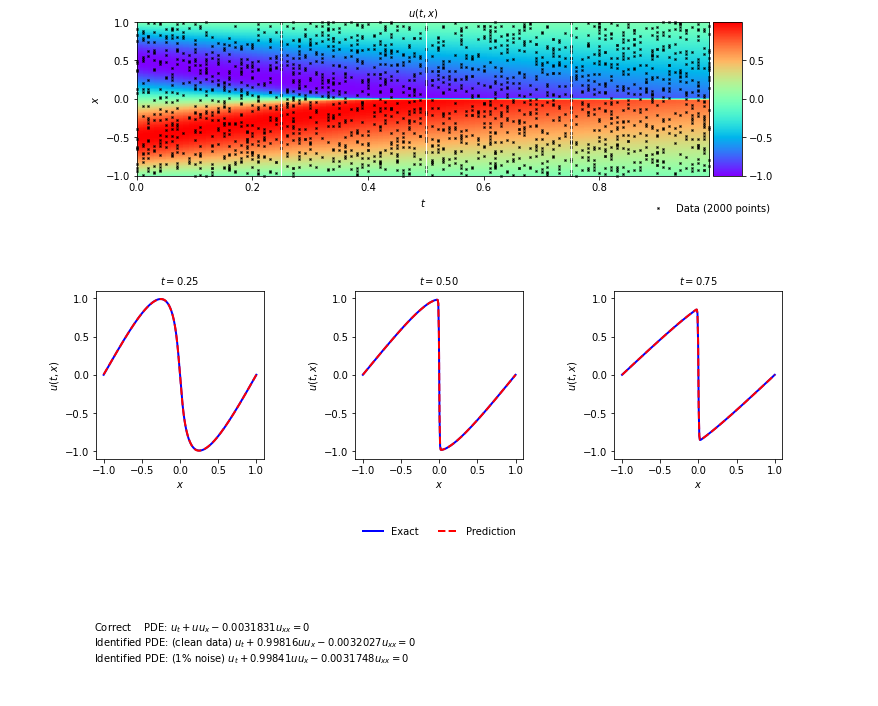

In [5]:
######################################################################
############################# Plotting ###############################
######################################################################    

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

####### Row 3: Identified PDE ##################    
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1.0-2.0/3.0, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

# s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.0031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
# s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
# s3 = r'Identified PDE (1\% noise) & '
# s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
# s5 = r'\end{tabular}$'
# s = s1+s2+s3+s4+s5


s = r"""
Correct    PDE: $u_t + u u_x - 0.0031831 u_{xx} = 0$
Identified PDE: (clean data) $u_t + 0.99816 u u_x - 0.0032027 u_{xx} = 0$
Identified PDE: (1% noise) $u_t + 0.99841 u u_x - 0.0031748 u_{xx} = 0$  
"""
ax.text(0.1,0.1,s)
plt.show()

测试 matplotlib

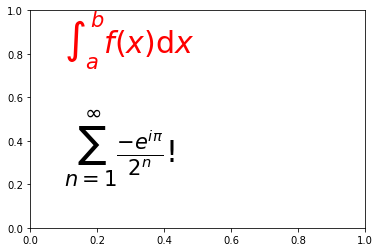

In [6]:
import matplotlib.pyplot as plt
ax=plt.subplot(111)
ax.text(0.1,0.8,r"$\int_a^b f(x)\mathrm{d}x$",fontsize=30,color="red")
ax.text(0.1,0.3,r"$\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}!$",fontsize=30)
plt.show()